In [45]:
import requests
import random
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from copy import deepcopy
from statistics import mean

In [46]:
def request() -> list:   
    res = requests.get('http://localhost:3000/api/ep1')
    return res.json()

In [47]:
def data_treatment(json:list) -> list:
    for i in range(len(json)):
        for key in json[i]:
            if ('prod' in key):
                if (type(json[i][key])!=dict):
                    qnt = json[i][key]
                    if (type(qnt)==str):
                        qnt = float(qnt)                  
                    if (qnt<0):
                        qnt = 0
                    if (key in [product for product in json[i] if ('prod' in product and (int(product[5]) < 9 and len(product) < 7))]):
                        json[i][key] = {'qnt':[round(qnt)], 'price':None}
                    else:
                        json[i][key] = {'qnt':[qnt], 'price':None}
        try:
            json[i]['date'] = time.ctime(json[i]['date'])
        except:
            continue
    return json

In [48]:
def generate_random_price(n_min=1.0, n_max=100.0) -> float:
    return round(random.uniform(n_min, n_max), 2)

In [49]:
def logistic_function(v: float) -> float:
    return 0.5 + (1 / (1 + math.e ** -v))

In [50]:
def calc_qnt_variation(last_week: list, current_week: list) -> float:
    return mean(current_week) - mean(last_week) / mean(last_week) if (mean(last_week) != 0) else 0

In [51]:
def calc_new_price(product_db: dict, sales_week: dict) -> dict:
    for product in product_db:
        if (product_db[product]['qnt'] != None):
            if (product not in sales_week.keys()):
                sales_week[product] = [0]
            product_db[product]['next_week_price'] = logistic_function(calc_qnt_variation(product_db[product]['qnt'], sales_week[product])) * product_db[product]['price']
        product_db[product]['qnt'] = sales_week[product]               
    return product_db

In [52]:
def product_pricing(json: list, product_db: dict) -> tuple:
    sales_week = {}

    for transaction in json:
        for key in transaction:
            if ('prod' in key):
                if (key not in product_db.keys()):
                    transaction[key]['price'] = generate_random_price()
                    sales_week[key] = deepcopy(transaction[key]['qnt'])
                    product_db[key] = deepcopy(transaction[key])
                    product_db[key]['qnt'] = None
                    product_db[key]['next_week_price'] = product_db[key]['price']              
                else:
                    transaction[key]['price'] = deepcopy(product_db[key]['next_week_price'])
                    product_db[key]['price'] = product_db[key]['next_week_price']
                    if (key not in sales_week.keys()):
                        sales_week[key] = deepcopy(transaction[key]['qnt'])
                    else:
                        sales_week[key] += deepcopy(transaction[key]['qnt'])
    product_db = calc_new_price(product_db, sales_week)
    return json, product_db

In [53]:
def df_to_all_df(json: list, all_df: pd.DataFrame, week: int) -> pd.DataFrame:
    for transaction in json:
        json_to_df = deepcopy(transaction)
        date = json_to_df['date']
        id = json_to_df['id']
        del json_to_df['date']
        del json_to_df['id']
        df = pd.DataFrame(json_to_df).T
        df['id'] = id
        df['date'] = date
        df['month'] = pd.to_datetime(df['date']).dt.to_period('M')
        df['week'] = week
        df = pd.concat([all_df, df])
        # df=df.set_index(['date','id'])
    return df

In [54]:
def format_all_df(all_df:pd.DataFrame) -> pd.DataFrame:
    all_df=all_df.reset_index().rename(columns={'index':'product'}).set_index('id').reset_index()
    all_df['qnt'] = [float(item[0]) for item in all_df['qnt']]
    return all_df

In [55]:
sum_all_prods = {f'prod_{i}':'sum' for i in range(20)}
sum_all_prods['balance']='sum'

In [56]:
def df_to_analysis(all_jsons:list, column_name:str):
    new_json = {}
    n = 0
    for week in range(len(all_jsons)):
        for transaction in range(len(all_jsons[week])):
            balance = 0
            new_json[n] = {}
            new_json[n]['date'] = all_jsons[week][transaction]['date']
            new_json[n]['week'] = f'Week {week+1}'
            new_json[n]['month']=all_jsons[week][transaction]['date']
            new_json[n]['id'] = all_jsons[week][transaction]['id']
            for i in range(0,21):
                new_json[n][f'prod_{i}'] = 0
            for key in all_jsons[week][transaction]:
                if ('prod' in key):
                    if (type(all_jsons[week][transaction][key][column_name])==list): #teste
                        new_json[n][key] = float(all_jsons[week][transaction][key][column_name][0])
                    else:
                        new_json[n][key] = float(all_jsons[week][transaction][key][column_name])
                    balance += new_json[n][key]
            n += 1  
    df = pd.DataFrame(new_json).T
    df['balance'] = balance
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['month'] = pd.to_datetime(df['month']).dt.month_name()


    return df

In [57]:
sum_all_prods = {f'prod_{i}':'sum' for i in range(20)}
sum_all_prods['balance']='sum'

In [58]:
product_database = {}
weeks = 8
all_df = pd.DataFrame([])
all_jsons = []

for week in range(weeks):
    json = data_treatment(request())
    json, product_database = product_pricing(json, product_database)
    all_df = df_to_all_df(json=json, all_df=all_df, week=week)
    all_jsons.append(json)
        
all_df=format_all_df(all_df=all_df)
all_df.to_csv('allsales.csv')

In [59]:
all_df.head()

,id,product,qnt,price,date,month,week
0,lamydtxxd7mu63uiyua,prod_0,34.0,31.85,Thu Apr 30 07:55:28 2020,2020-04,0
1,lamydtxxd7mu63uiyua,prod_2,1.0,43.82,Thu Apr 30 07:55:28 2020,2020-04,0
2,lamydtxxd7mu63uiyua,prod_5,41.0,90.44,Thu Apr 30 07:55:28 2020,2020-04,0
3,lamydtxxd7mu63uiyua,prod_7,40.0,5.29,Thu Apr 30 07:55:28 2020,2020-04,0
4,lamydtxxd7mu63uiyua,prod_8,7.0,43.67,Thu Apr 30 07:55:28 2020,2020-04,0


In [60]:
def plot_prod_qnt(all_df):
    group_qnt = all_df.groupby('product')['qnt'].sum()
    df_prod = pd.DataFrame(group_qnt)
    plot_prod = df_prod.plot(kind='bar')
    return plot_prod

In [61]:
def plot_month_balance(all_df):
    df_balance = all_df.copy()
    df_balance['balance'] = df_balance['qnt'] * df_balance['price']
    df_months_balance = pd.DataFrame(df_balance.groupby('month')['balance'].sum())
    plot_months = df_months_balance.plot(kind='pie', subplots=True)
    return plot_months

<AxesSubplot:xlabel='product'>

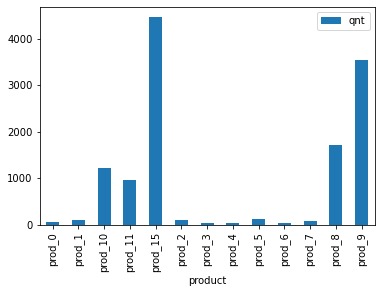

In [62]:
plot_prod_qnt(all_df)

array([<AxesSubplot:ylabel='balance'>], dtype=object)

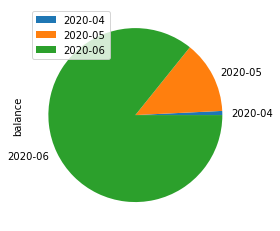

In [63]:
plot_month_balance(all_df) 

In [64]:
all_qnt= df_to_analysis(all_jsons=all_jsons, column_name='qnt')
all_qnt.head()

,date,week,month,id,prod_0,prod_1,prod_2,prod_3,prod_4,prod_5,...,prod_12,prod_13,prod_14,prod_15,prod_16,prod_17,prod_18,prod_19,prod_20,balance
0,2020-04-29,Week 1,April,lamydtxwtbfnegh9tlm,0,9.0,32.0,0,0,13.0,...,0,0,0,283.950711,0,0,0,0,0,1780.202555
1,2020-04-29,Week 1,April,lamydtxxj0b6g2ktgdg,0,27.0,0,20.0,0,0,...,0,0,0,66.938944,0,0,0,0,0,1780.202555
2,2020-04-29,Week 1,April,lamydtxxhfrirl0xkhe,15.0,15.0,10.0,0,0,26.0,...,0,0,0,445.769036,0,0,0,0,0,1780.202555
3,2020-04-30,Week 1,April,lamydtxxqkcw06739q,0,0,24.0,0,0,6.0,...,0,0,0,116.978356,0,0,0,0,0,1780.202555
4,2020-04-29,Week 1,April,lamydtxxfv9fbeio9r,28.0,23.0,0,0,0,0,...,0,0,0,356.096908,0,0,0,0,0,1780.202555


In [71]:
def all_sales_csv(all_jsons):
    all_qnt= df_to_analysis(all_jsons=all_jsons, column_name='qnt')
    all_qnt.to_csv('all_sales.csv', index=False)
    return all_qnt

In [72]:
all_sales_csv(all_jsons)

,date,week,month,id,prod_0,prod_1,prod_2,prod_3,prod_4,prod_5,...,prod_12,prod_13,prod_14,prod_15,prod_16,prod_17,prod_18,prod_19,prod_20,balance
0,2020-04-29,Week 1,April,lamydtxwtbfnegh9tlm,0,9.0,32.0,0,0,13.0,...,0,0,0,283.950711,0,0,0,0,0,1780.202555
1,2020-04-29,Week 1,April,lamydtxxj0b6g2ktgdg,0,27.0,0,20.0,0,0,...,0,0,0,66.938944,0,0,0,0,0,1780.202555
2,2020-04-29,Week 1,April,lamydtxxhfrirl0xkhe,15.0,15.0,10.0,0,0,26.0,...,0,0,0,445.769036,0,0,0,0,0,1780.202555
3,2020-04-30,Week 1,April,lamydtxxqkcw06739q,0,0,24.0,0,0,6.0,...,0,0,0,116.978356,0,0,0,0,0,1780.202555
4,2020-04-29,Week 1,April,lamydtxxfv9fbeio9r,28.0,23.0,0,0,0,0,...,0,0,0,356.096908,0,0,0,0,0,1780.202555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2020-06-17,Week 8,June,lamydug5ayqnq7mo6o,48.0,39.0,34.0,0,0,41.0,...,0,0,0,758.979091,0,0,0,0,0,1780.202555
121,2020-06-17,Week 8,June,lamydug5vv17ywi5yu,39.0,0,19.0,48.0,0,0,...,0,0,0,460.656119,0,0,0,0,0,1780.202555
122,2020-06-18,Week 8,June,lamydug5ps2ns59yv3s,28.0,2.0,0,18.0,45.0,22.0,...,0,0,0,182.010283,0,0,0,0,0,1780.202555
123,2020-06-17,Week 8,June,lamydug5jivbc6ajvni,0,0,30.0,0,43.0,15.0,...,0,0,0,406.436402,0,0,0,0,0,1780.202555
